<a href="https://colab.research.google.com/github/amd257/COVID-detection-using-CNNs/blob/FinalRound/ParallSequentialModel_Binary_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Compressed Binary Classification Dataset file is stored at: https://www.dropbox.com/s/dhu2h2me4ccpe9h/BinaryDataset.zip?dl=0
!wget https://www.dropbox.com/s/dhu2h2me4ccpe9h/BinaryDataset.zip?dl=0

--2021-03-09 20:43:29--  https://www.dropbox.com/s/dhu2h2me4ccpe9h/BinaryDataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dhu2h2me4ccpe9h/BinaryDataset.zip [following]
--2021-03-09 20:43:29--  https://www.dropbox.com/s/raw/dhu2h2me4ccpe9h/BinaryDataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb057f416d8dc21fef892eb4250.dl.dropboxusercontent.com/cd/0/inline/BKZWBvfeRWn2t641G9zWidAYpAcGODxrUz_a5TNSKcWYlkQlC51EZnPzSM063Yy5qIla33h9KwJK0-l_9bHKacbRtrepz3x0Hpo3plRoC8iGEzYf7UgSVr6ecWNakSjcPPDqu0vPN3ytdsG_51tp35Sz/file# [following]
--2021-03-09 20:43:29--  https://ucb057f416d8dc21fef892eb4250.dl.dropboxusercontent.com/cd/0/inline/BKZWBvfeRWn2t641G9zWidAYpAcGODxrUz_a5TNSKcWYlkQlC51EZnPzSM063Yy5qIla33

In [ ]:
#Extracting the compressed dataset
!unzip /content/BinaryDataset.zip?dl=0

In [10]:
#Importing all the libraries required for preprocessing, training and evaluation of the model
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory #Importing Functions for image preprocessing from keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau #Importing Functions for early stopping and learning rate reduction
from sklearn.utils import class_weight #Importing functions for computing class weights from scikit learn class_weight module
from keras.utils import plot_model
from keras.preprocessing import image
from keras.layers import *
from keras.models import * #Importing the functions required for creating the model
import matplotlib.pyplot as plt #For plotting the training and validation loss and accuracy graphs
import numpy as np
import pandas as pd

In [11]:
train_images_path = "BinaryDataset/Train"
validation_images_path = "BinaryDataset/Validation"
test_images_path = "BinaryDataset/Test"
image_height = 100
image_width = 100

In [12]:
#Training data augmentation before feeding it to the CNN model
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,  #flipping will add more variations to the data and it will help fight overfitting as welll
    )

#Preprocessing the training dataset
train_dataset= train_datagen.flow_from_directory(
    train_images_path,
    target_size = (image_height,image_width), 
    batch_size = 32,
    color_mode="grayscale",
    class_mode = "binary", #class mode is binary for binary classification
    shuffle = True,
    seed =50
    )

inp_shape= train_dataset.image_shape
print("Input Shape: " , inp_shape)
print("Class Labels: ", train_dataset.class_indices)

Found 3108 images belonging to 2 classes.
Input Shape:  (100, 100, 1)
Class Labels:  {'COVID': 0, 'Non-COVID': 1}


In [13]:
validation_datagen = image.ImageDataGenerator(rescale = 1./255) #Rescaling the validation images 

#Preprocessing the validation dataset
validation_dataset = validation_datagen.flow_from_directory(
    validation_images_path,
    target_size = (image_height,image_width),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "binary",
    shuffle = True,
    seed =40
    )

Found 388 images belonging to 2 classes.


In [14]:
test_datagen = image.ImageDataGenerator(rescale = 1./255) #Rescaling the test images 

#Preprocessing the testing dataset
test_dataset = test_datagen.flow_from_directory(
    test_images_path,
    target_size = (image_height,image_width),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "binary",
    shuffle = True,
    seed =20
    )

Found 312 images belonging to 2 classes.


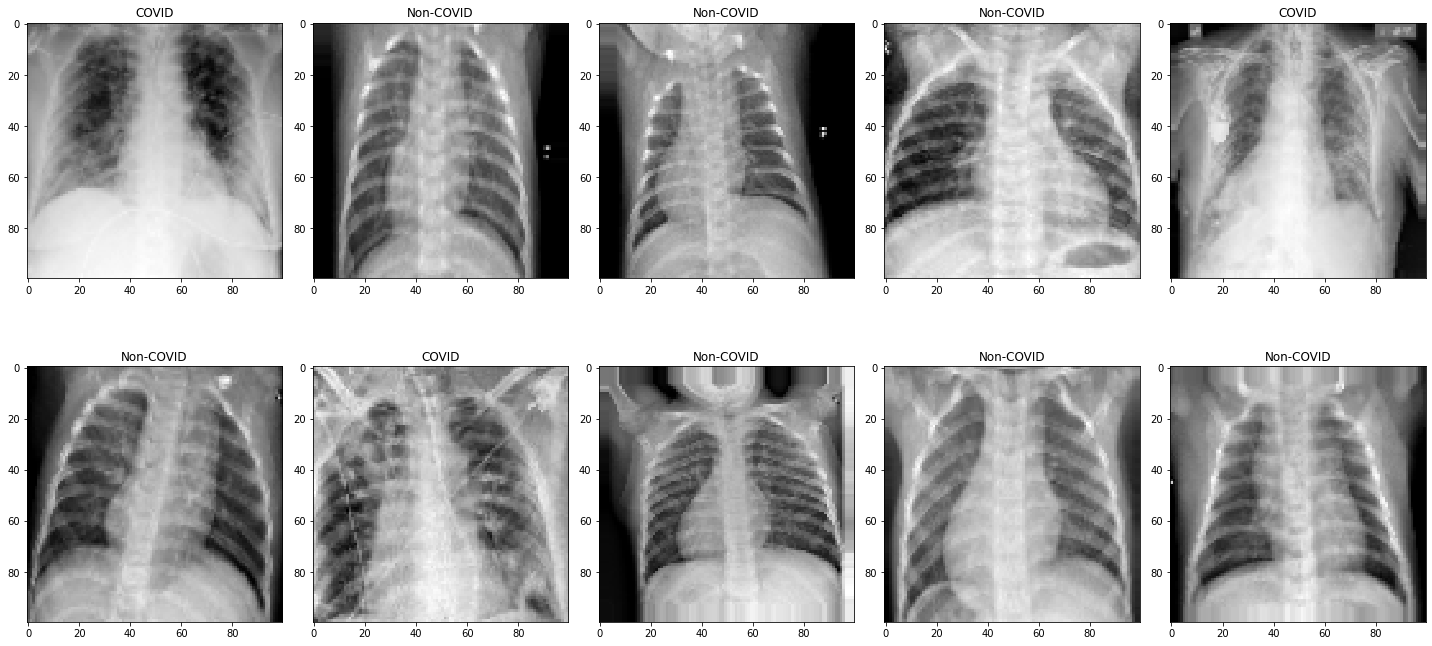

In [16]:
#Visualization of Preprocessed Data
plt.figure(figsize=(20, 10))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_dataset:
        image = X_batch[0]        
        dic = {0: 'COVID', 1:'Non-COVID'} 
        plt.title(dic.get(Y_batch[0])) #to get index of the image label
        plt.axis('on')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [28]:
#Creating the parallel sequential model
input_shape = inp_shape
input=Input(shape = input_shape) 
convs=[]
parrallel_kernels=[3,5,7]

for i in range(len(parrallel_kernels)):
  conv = Conv2D(128, parrallel_kernels[i],padding = 'same',activation='relu',input_shape=input_shape,strides=1)(input)
  convs.append(conv)

output = Concatenate()(convs)
conv_model = Model(input,output)

print(input_shape)
print(input)

(100, 100, 1)
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [29]:
model = Sequential()
model.add(conv_model) # Added the conv_model with the parallel kernels to the sequential model

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid')) #check out sigmoid as well
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.input.shape)
model.summary()

(None, 100, 100, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 100, 100, 384)     11008     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 98, 98, 64)        221248    
_________________________________________________________________
activation_2 (Activation)    (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 47, 47, 32)        18464     
_________________________________________________________________
activation_3 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None

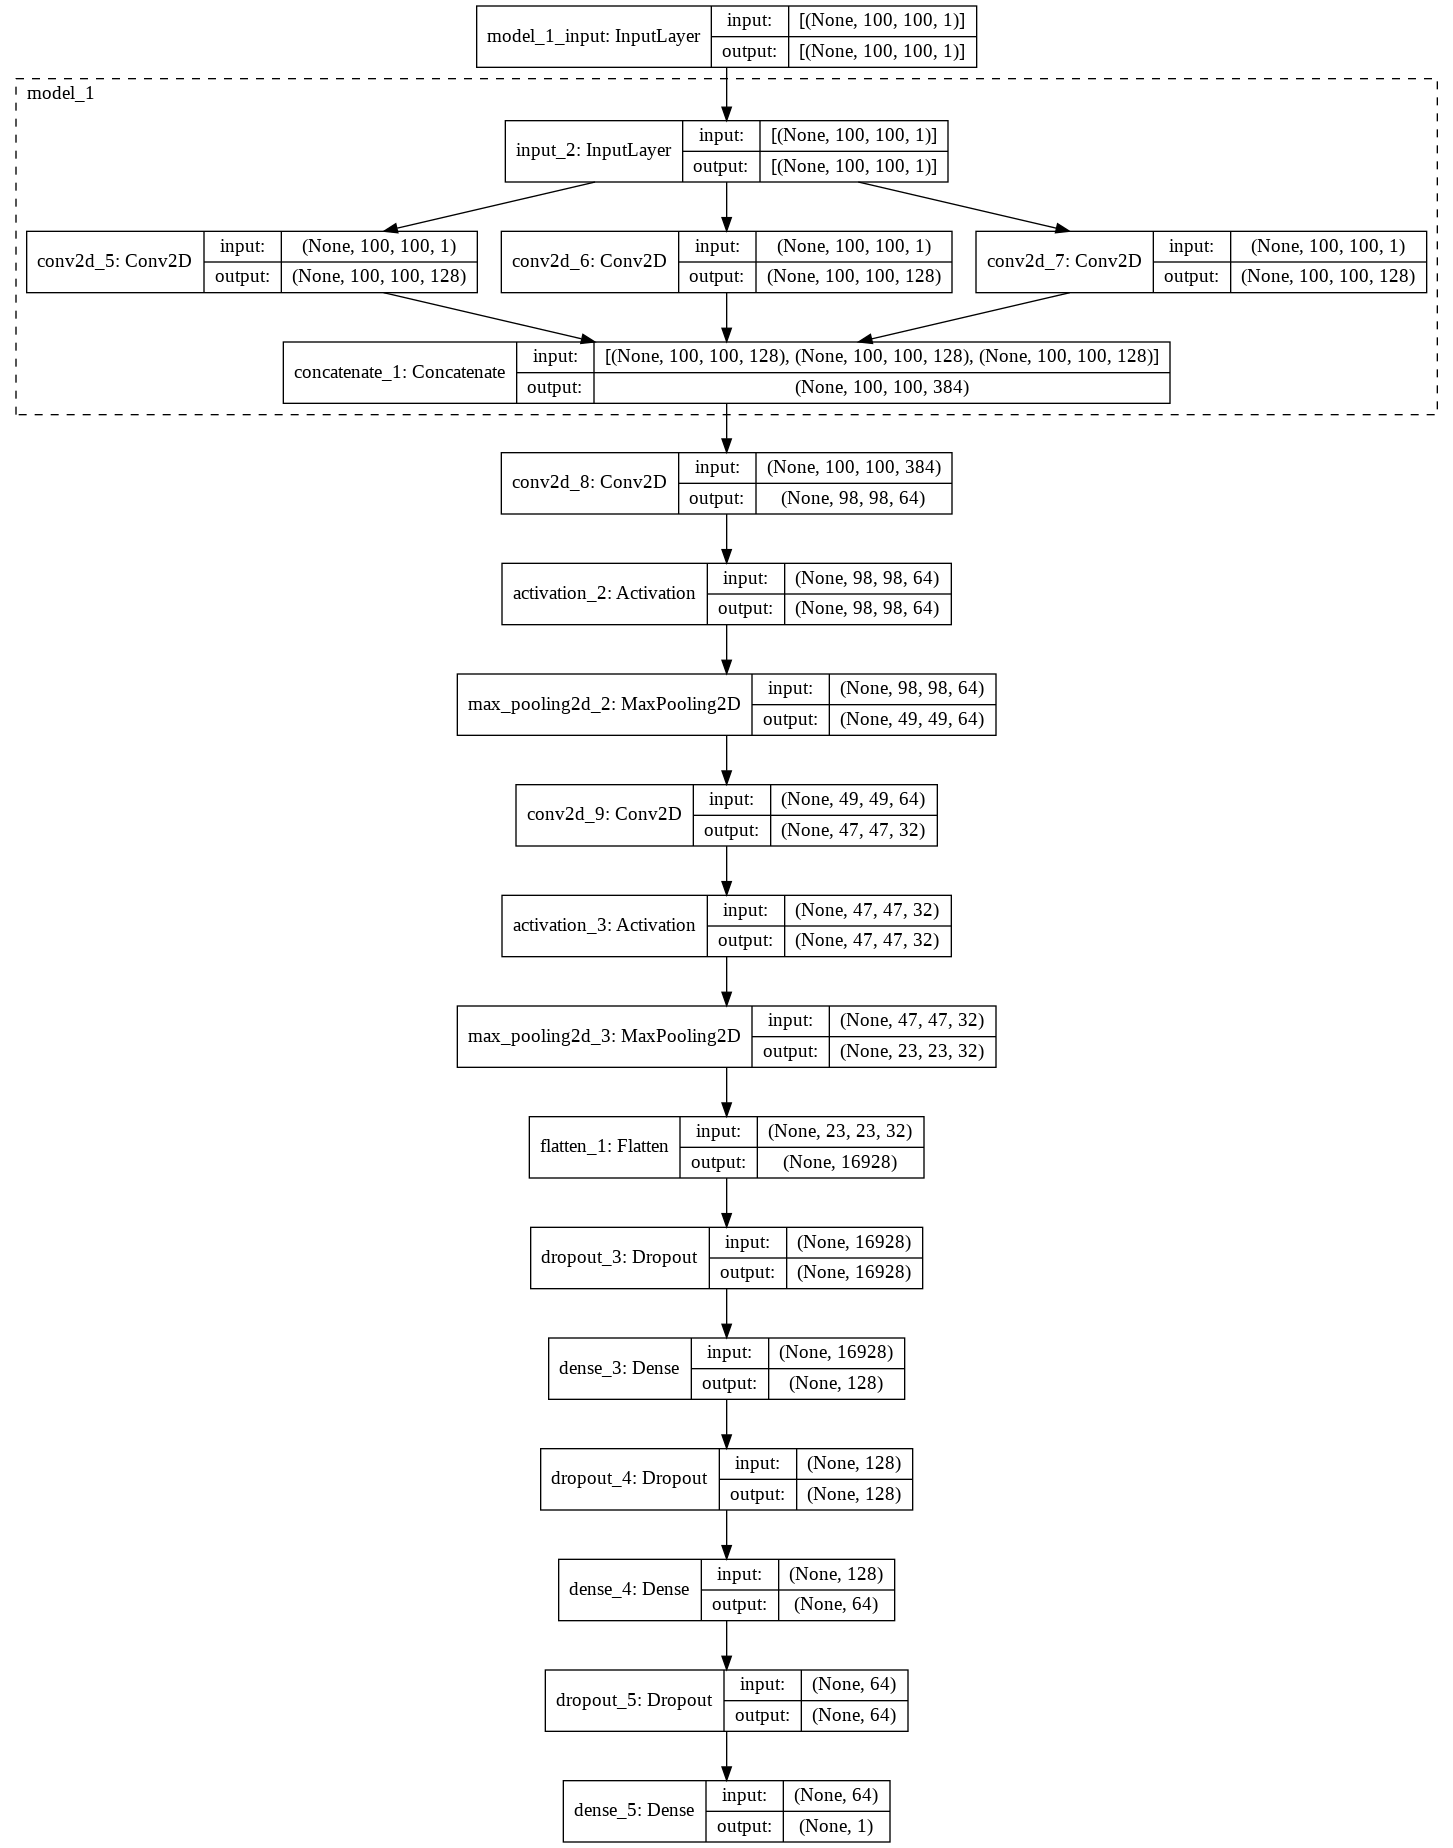

In [30]:
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [31]:
STEP_SIZE_TRAIN=train_dataset.n//train_dataset.batch_size
STEP_SIZE_VALID=validation_dataset.n//validation_dataset.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

97
12


In [32]:
#Defining functions for early stopping and adjusting the learning rate during model training 
earlyStop = EarlyStopping(monitor="val_loss", mode="min", patience=4, verbose= 1)
learningRateReduce = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.4, min_lr=0.0000001)
callbacksList = [ earlyStop, learningRateReduce]

In [33]:
#Assigning class weights using the compute class weights function
classWeights = class_weight.compute_class_weight('balanced', np.unique(train_dataset.classes), train_dataset.classes)
classWeightsDict = dict(enumerate(classWeights))
print("The class weights to be assigned to each label are:", classWeightsDict)

The class weights to be assigned to each label are: {0: 1.61875, 1: 0.723463687150838}


In [34]:
hist = model.fit(
    train_dataset, 
    steps_per_epoch = STEP_SIZE_TRAIN, 
    epochs=100,
    validation_data = validation_dataset,
    validation_steps = STEP_SIZE_VALID,
    class_weight = classWeightsDict,
    callbacks=callbacksList
    )

Epoch 1/100
97/97 [==============================] - 42s 424ms/step - loss: 0.6054 - accuracy: 0.6781 - val_loss: 0.1893 - val_accuracy: 0.9583
Epoch 2/100
97/97 [==============================] - 40s 416ms/step - loss: 0.2764 - accuracy: 0.9060 - val_loss: 0.1207 - val_accuracy: 0.9714
Epoch 3/100
97/97 [==============================] - 41s 418ms/step - loss: 0.2143 - accuracy: 0.9391 - val_loss: 0.1289 - val_accuracy: 0.9688
Epoch 4/100
97/97 [==============================] - 40s 414ms/step - loss: 0.1802 - accuracy: 0.9423 - val_loss: 0.1933 - val_accuracy: 0.9375

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 5/100
97/97 [==============================] - 41s 418ms/step - loss: 0.1457 - accuracy: 0.9489 - val_loss: 0.1020 - val_accuracy: 0.9740
Epoch 6/100
97/97 [==============================] - 40s 415ms/step - loss: 0.1409 - accuracy: 0.9498 - val_loss: 0.0804 - val_accuracy: 0.9714
Epoch 7/100
97/97 [==============================] - 40

In [56]:
model.save('ParallelSeqModel_Binary_Final.h5') #Saving the model
#model = load_model('/content/ParallelSeqModel_Binary_Final.h5') #for loading the model

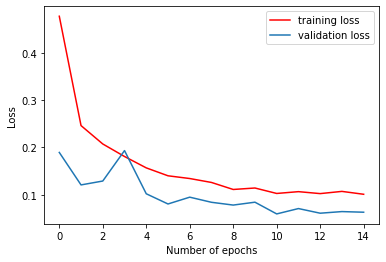

In [52]:
#Plotting the graph for training and validation loss

plt.locator_params(axis='x', integer=True, tight=True) #To ensure no. of epochs is shown as integers
plt.plot(hist.history['loss'],'r',label='training loss')
plt.plot(hist.history['val_loss'],label='validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

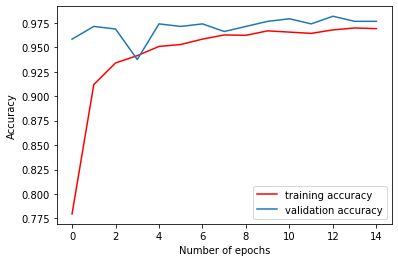

In [53]:
#Plotting the graph for training and validation accuracy

plt.locator_params(axis='x', integer=True, tight=True) 
plt.plot(hist.history['accuracy'],'r',label='training accuracy')
plt.plot(hist.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

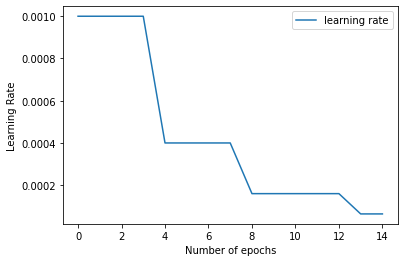

In [54]:
#Plotting the graph for learning rate

plt.locator_params(axis='x', integer=True, tight=True) 
plt.plot(hist.history['lr'],label='learning rate')
plt.xlabel('Number of epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

In [55]:
testingAccuracy = model.evaluate(test_dataset) #Evaluating the model on the testing dataset
print("The Parallel Sequential Model for binary classification has a testing accuracy of:", testingAccuracy[1]*100, "%")

10/10 [==============================] - 3s 331ms/step - loss: 0.0966 - accuracy: 0.9679
The Parallel Sequential Model for binary classification has a testing accuracy of: 96.79487347602844 %
